# Linking business metrics with our ML models

Data is from [this dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) to predict churn from a telecom company.


"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]"

<a target="_blank" href="https://colab.research.google.com/github/josearangos/Talks/blob/main/%5Blatest%5D%202024-06-31%20-%20UdeA%20Web3ForU%20-%20ML%20for%20Business%20Decision%20Optimization/ML_for_Business_Decision_Optimization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Module 1: Profit Curves

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc, RocCurveDisplay,accuracy_score
from sklearn.compose import make_column_selector as selector
from xgboost import XGBClassifier
plt.style.use('fivethirtyeight')

In [2]:
# Imports for JupyterLite
%%capture
%pip install -q ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 1. Download dataset

In [3]:
%%capture
!pip install gdown

In [4]:
%ls -l

total 4
drwxr-xr-x 1 root root 4096 May 29 21:54 sample_data/


In [5]:
import gdown

# URL of the public Google Drive file
file_id = "10laBvh171JLkm-A8MEX_8pApwgh61KiS"
file_url = f'https://drive.google.com/uc?id={file_id}'

# Name of the file to save locally
local_file_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Download the file
gdown.download(file_url, local_file_path, quiet=False)

print(f'File downloaded as {local_file_path}')

Downloading...
From: https://drive.google.com/uc?id=10laBvh171JLkm-A8MEX_8pApwgh61KiS
To: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv
100%|██████████| 978k/978k [00:00<00:00, 30.5MB/s]

File downloaded as WA_Fn-UseC_-Telco-Customer-Churn.csv


In [6]:
%ls -l

total 960
drwxr-xr-x 1 root root   4096 May 29 21:54 sample_data/
-rw-r--r-- 1 root root 977501 May 31 02:27 WA_Fn-UseC_-Telco-Customer-Churn.csv


In [7]:
data = pd.read_csv(local_file_path)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Split data

In [8]:
target = "Churn"
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1), data[target] == "Yes", test_size=0.2, random_state=0
)

## 3. Data preprocessing

In [9]:
cols_to_use = [
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
]

preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), selector(dtype_include="object"))],
    remainder="passthrough",  # Leave numerical variables unchanged
)

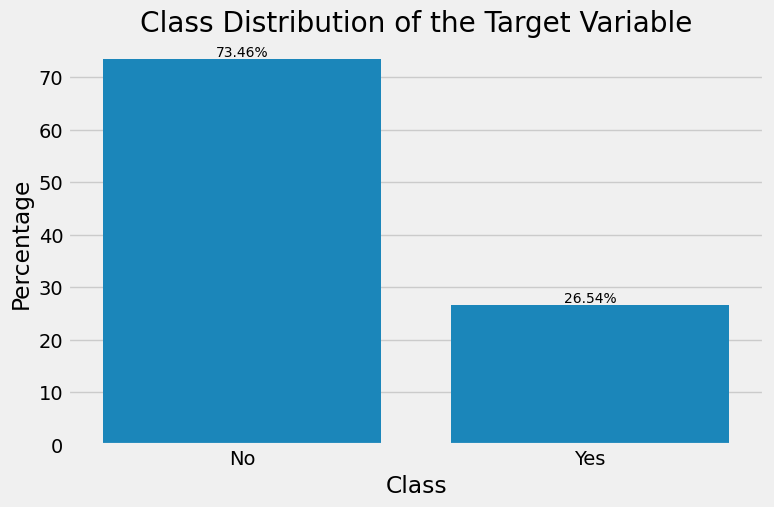

In [10]:
# Calculate the percentage
class_counts = data[target].value_counts()
total_samples = class_counts.sum()
class_percentages = class_counts / total_samples * 100

# Visualization of the class distribution with exact percentages
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=class_counts.index, y=class_percentages.values)
plt.title('Class Distribution of the Target Variable')
plt.xlabel('Class')
plt.ylabel('Percentage')

# Annotate bars with exact percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

## 4. Create train/test pipeline

In [11]:
# Create pipeline
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier())])

## 5. Train

In [12]:
X_train[cols_to_use].head()

,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2920,72,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,85.10
2966,14,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,46.35
6099,71,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.70
5482,33,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,73.90
2012,47,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,98.75


In [13]:
X_train[cols_to_use].dtypes

tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
dtype: object

In [14]:
pipeline.fit(X_train[cols_to_use], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbd15822aa0>)])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

## 6.Test

In [15]:
"""
- Column 0: No Churn (probability)
- Column 1: Churn (probability)
"""

#Class 1: Probabilities
y_pred_proba = pipeline.predict_proba(X_test[cols_to_use])[:, 1] # Column 1: Churn (probability)

In [16]:
pipeline.predict_proba(X_test[cols_to_use])

array([[0.9633266 , 0.03667343],
       [0.94567764, 0.05432237],
       [0.56311214, 0.43688783],
       ...,
       [0.8209969 , 0.17900313],
       [0.91252804, 0.08747198],
       [0.25810897, 0.741891  ]], dtype=float32)

In [17]:
# The .predict method selects the class with the highest probability
y_pred = pipeline.predict(X_test[cols_to_use])
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [18]:
def compute_metrics(y_test,y_pred_proba ):
  roc_auc_value = roc_auc_score(y_test, y_pred_proba) #Label and probabilities
  log_loss_val = log_loss(y_test, y_pred_proba)
  accuracy = accuracy_score(y_true = y_test, y_pred=y_pred) #y_pred No y_pred_proba

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_proba)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value,
                                    estimator_name='example estimator')
  display.plot()
  plt.title("ROC Curve")
  plt.show()

  print("ROC AUC:", roc_auc_value)
  print("ACCURACY", accuracy)

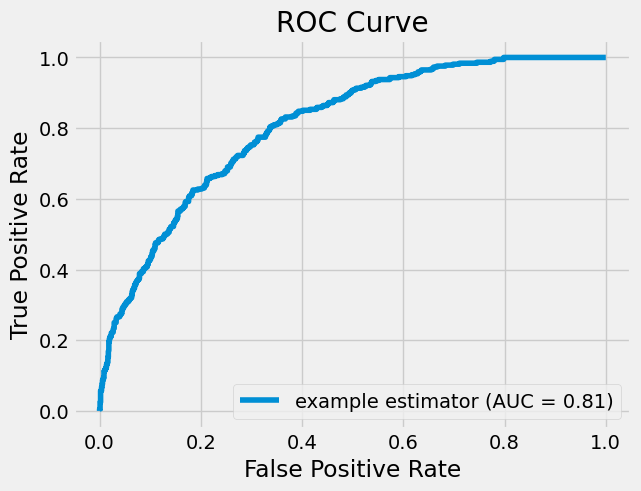

ROC AUC: 0.8070730484901641
ACCURACY 0.7707594038325053


In [19]:
compute_metrics(y_test=y_test,y_pred_proba=y_pred_proba)

### Convert probability prediction to label (1,0)

In [20]:
def confusion_matrix_change_by_threshold(threshold:float=0.6):

  y_pred_binary = np.where(y_pred_proba >= threshold, 1, 0)

  cm = confusion_matrix(y_true = y_test, y_pred=y_pred_binary)

  # confusion_matrix format:
  # [[TN, FP],
  #  [FN, TP]]

  temporal_accuracy = accuracy_score(y_true = y_test, y_pred=y_pred_binary)

  cm = confusion_matrix(y_test, y_pred_binary, labels=pipeline.classes_,normalize="true")
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pipeline.classes_)


  disp = disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion matrix normalized")
  plt.show()
  print("Accuracy:",temporal_accuracy)

## 7. Interaction between threshold and predictions

In [21]:
interact(confusion_matrix_change_by_threshold, threshold=(0.0,1.0,0.1));

interactive(children=(FloatSlider(value=0.6, description='threshold', max=1.0), Output()), _dom_classes=('widg…

## 8.  Profit curve

###  **Payoff_matrix**

IMPORTANT!!!

In [22]:
# Costs $80 to give discount to a customer who will not churn (Fase Positive) FP (BAD) 👎
# Worth $200 to give discount to a customer who will otherwise churn (True Positive) TP (GOOD) 👍
payoff_matrix = np.array([[0, -80], [0, 200]])

# format is
# [[TN, FP],
#  [FN, TP]]
print(payoff_matrix)

[[  0 -80]
 [  0 200]]


In [23]:
def profit_curve(y_true, y_pred_proba, payoff_matrix, n_points=101):
    """Calculate profit curve for a binary classifier.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted probabilities.
        payoff_matrix (array-like): Payoff matrix.
        n_points (int): Number of points to calculate.

    Returns:
        tuple: x and y values for the profit curve.
    """
    # Calculate profit for each threshold
    thresholds = np.linspace(0, 1, n_points)
    profits = []
    for threshold in thresholds:
        y_pred_binary = np.where(y_pred_proba >= threshold, 1, 0)
        cm = confusion_matrix(y_true, y_pred_binary)
        profit = (cm * payoff_matrix).sum()
        profits.append(profit)

    return thresholds, profits

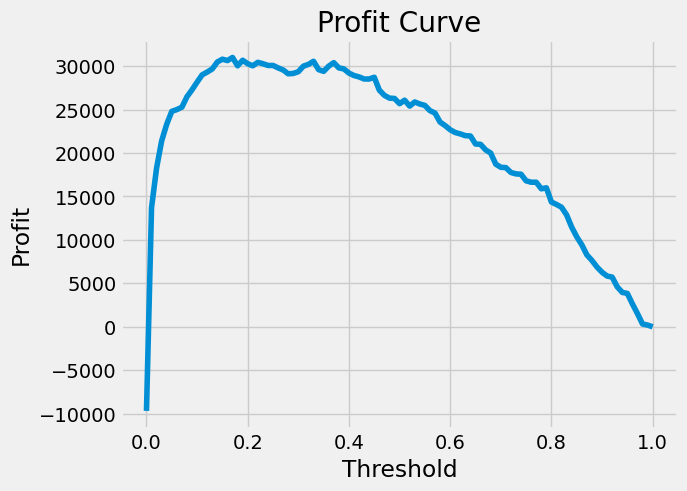

In [24]:
thresholds, profits = profit_curve(y_test, y_pred_proba, payoff_matrix)
plt.plot(thresholds,profits)
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title("Profit Curve")
plt.show()

### Best threshold that maximizes profit

In [25]:
def find_best_threshold_and_profit(thresholds, profits):
    """Find the best threshold and profit.

    Args:
        thresholds (array-like): Threshold values.
        profits (array-like): Profit values.

    Returns:
        tuple: Best threshold and profit.
    """
    best_profit_value = max(profits)
    best_profit_index = profits.index(best_profit_value)
    best_threshold = thresholds[best_profit_index]
    return best_threshold, best_profit_value

In [26]:
def plot_profit_curve(thresholds,profits,best_threshold,best_profits, title="Profit Curve"):
  plt.plot(thresholds,profits)
  plt.axhline(y=best_profits, color='red', linestyle='--', label="Best profit(USD) = "+str(best_profits))
  plt.axvline(x=best_threshold, color='green', linestyle='--', label="Best threshold = "+str(best_threshold))
  plt.xlabel('Threshold')
  plt.ylabel('Profit')
  plt.title(title)
  plt.legend()
  plt.show()

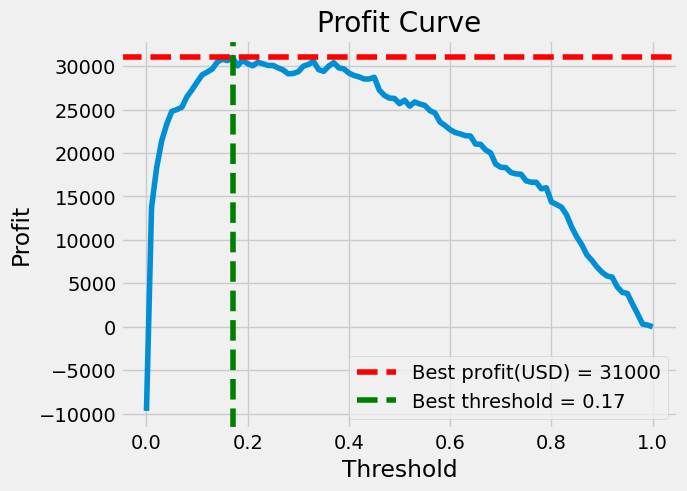

('0.17', 31000)

In [27]:
best_threshold, best_profits = find_best_threshold_and_profit(thresholds, profits)
plot_profit_curve(thresholds,profits,best_threshold,best_profits)
str(best_threshold),best_profits

In [28]:
print(f"Ideal threshold is {best_threshold:.2f} which yields profits of ${best_profits:.0f}")

Ideal threshold is 0.17 which yields profits of $31000


# Module 2: Feature importance based on profit curve


**Having a broken data pipeline - Prioritizing Work**

The decision to exclude the field that was lost or recover it carries a lot of work and potential monetary value behind it, so stay tuned to learn how to best navigate this situation.

In [29]:
cols_to_use, len(cols_to_use)

(['tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges'],
 14)

In [30]:
field_lost_in_broken_pipeline = "tenure"

## 1. Extract lost field

In [31]:
# refit model and get new predictions without this field
new_cols_to_use = [col for col in cols_to_use if col != field_lost_in_broken_pipeline]

In [32]:
len(cols_to_use), len(new_cols_to_use)

(14, 13)

## 2. Train with lost field

In [33]:
pipeline.fit(X_train[new_cols_to_use], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbd15822aa0>)])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

## 3.Compute metrics

In [34]:
new_y_pred_proba = pipeline.predict_proba(X_test[new_cols_to_use])[:, 1]

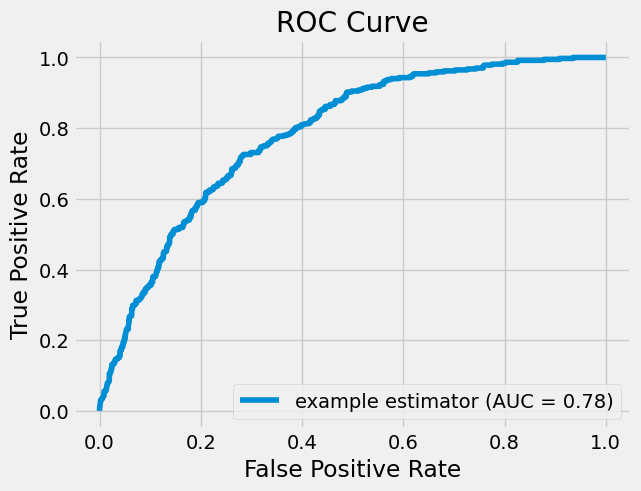

ROC AUC: 0.7828632063651172
ACCURACY 0.7707594038325053


In [35]:
compute_metrics(y_test=y_test,y_pred_proba=new_y_pred_proba)

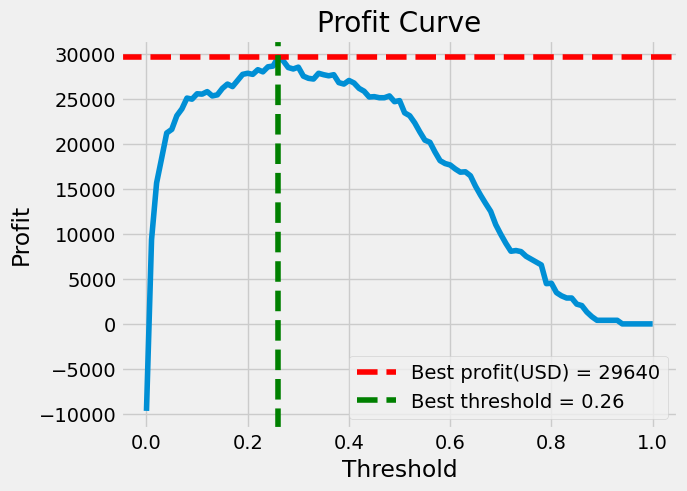

Ideal threshold is 0.26 which yields profits of $29640


In [36]:
new_thresholds, new_profits = profit_curve(y_test, new_y_pred_proba, payoff_matrix)
new_best_thresh, new_best_profits = find_best_threshold_and_profit(new_thresholds, new_profits)
plot_profit_curve(new_thresholds,new_profits,new_best_thresh,new_best_profits)
print(f"Ideal threshold is {new_best_thresh:.2f} which yields profits of ${new_best_profits:.0f}")

## IMPORTANT!!!


The most important field is **tenure**. It is an interesting exercise to see modify this code slightly and see how the results change when you remove tenure. We can lose 1360 Dollars

In [37]:
print(f"Change in profit due to lost field: {new_best_profits - best_profits:.0f}")

Change in profit due to lost field: -1360


# Module 3: Beyond Simple-Number Decision Thresholds

As you can see, there are different customers groups, someone's spend more money monthly than others.

Text(0, 0.5, 'Frequency')

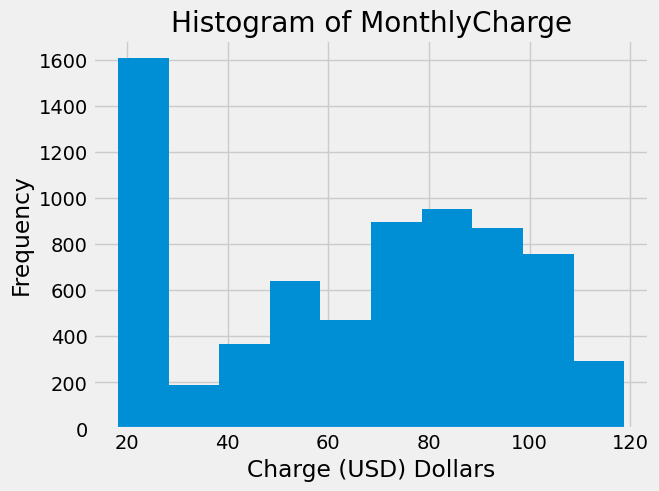

In [38]:
data.MonthlyCharges.hist()
plt.title("Histogram of MonthlyCharge")
plt.xlabel("Charge (USD) Dollars")
plt.ylabel("Frequency")

In [39]:
"""
# Previously assumed this was 200 for all customers.
# Mean MonthlyCharge is 68
X_test["value_of_promoting_to_churning_customer"] = data.MonthlyCharges * 3
# Previously assumed this was -80 for all customers.
X_test["cost_of_promoting_to_non_churning_customer"] = -80
"""

'\n# Previously assumed this was 200 for all customers.\n# Mean MonthlyCharge is 68\nX_test["value_of_promoting_to_churning_customer"] = data.MonthlyCharges * 3\n# Previously assumed this was -80 for all customers.\nX_test["cost_of_promoting_to_non_churning_customer"] = -80\n'

In [40]:
def group_specific_profit_curve(X_test, y_test, y_pred, low_thresh, high_thresh,title):
    #filter group
    in_group = (X_test.MonthlyCharges > low_thresh) & (
        X_test.MonthlyCharges <= high_thresh
    )
    y_test_in_group = y_test[in_group]
    y_pred_in_group = y_pred[in_group]

    mean_monthly_charge = X_test.MonthlyCharges[in_group].mean()

    payoff_matrix = np.array([[0, -80], [0, 3 * mean_monthly_charge]])

    thresholds, profits = profit_curve(y_test_in_group, y_pred_in_group, payoff_matrix)
    best_thresh, best_profits = find_best_threshold_and_profit(thresholds, profits)

    plot_profit_curve(thresholds,profits,best_thresh,best_profits,title)
    return best_thresh, best_profits

## 1.Divide customers into three groups and assign different thresholds for each

Threshold for customers paying less than $20/month


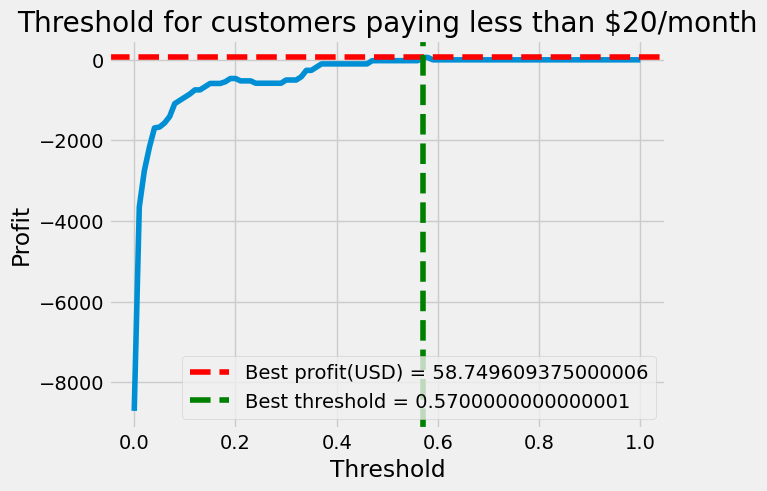

Threshold for customers paying between $20 and $60/month


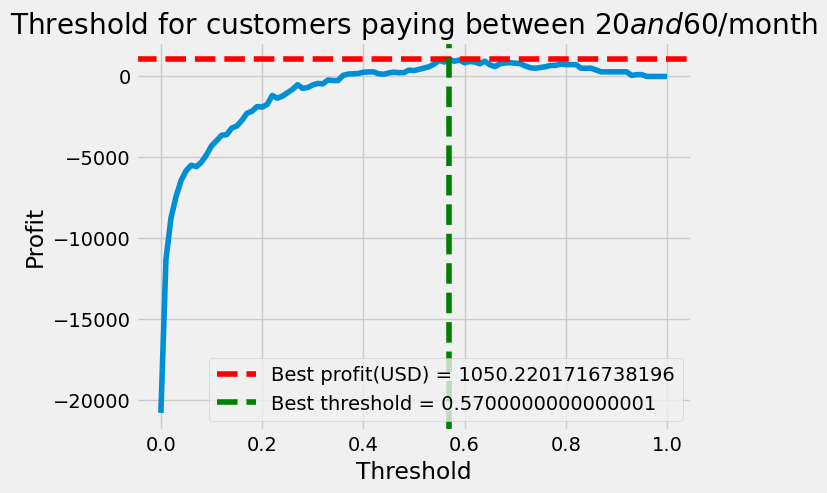

Threshold for customers paying between $60 and $100/month


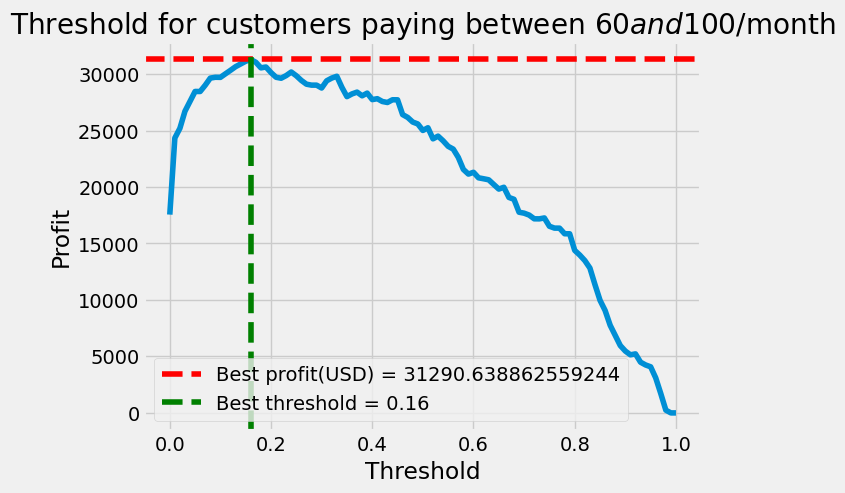

Threshold for customers paying more than $100/month


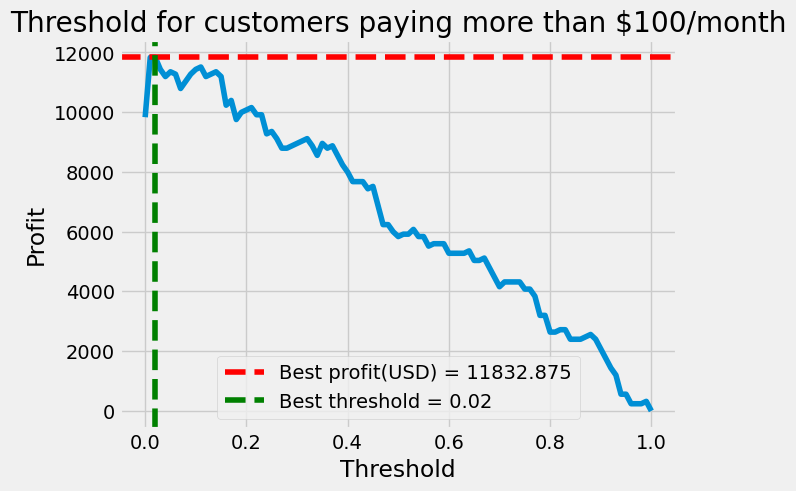

In [41]:
# Find ideal threshold for customers paying less than $20/month
title = "Threshold for customers paying less than $20/month"
print(title)
thresh_low, profits_low = group_specific_profit_curve(X_test, y_test, y_pred_proba, 0, 20,title)


# Find ideal threshold for customers paying between $20 and $60/month
title="Threshold for customers paying between $20 and $60/month"
print(title)
thresh_medium, profits_medium = group_specific_profit_curve(
    X_test, y_test, y_pred_proba, 20, 60,title
)

# Find ideal threshold for customers paying between $60 and $100/month
title="Threshold for customers paying between $60 and $100/month"
print(title)
thresh_high, profits_high = group_specific_profit_curve(X_test, y_test, y_pred_proba, 60, 100,title)


# Find ideal threshold for customers paying more than $100/month
title = "Threshold for customers paying more than $100/month"
print(title)
thresh_very_high, profits_very_high = group_specific_profit_curve(
    X_test, y_test, y_pred_proba, 100, 200, title
)


In [42]:
flexible_threshold_profit =profits_low + profits_medium + profits_high + profits_very_high

In [43]:
print(
    f"""
With flexible thresholds, the profit is {(flexible_threshold_profit):.0f}.
Previous profit was {best_profits}"""
)


With flexible thresholds, the profit is 44232.
Previous profit was 31000


In [44]:
print(f"{flexible_threshold_profit - best_profits:0.0f}")

13232




> ### **13.232$ USD - More dollars with a simple decision**



# Module 4: Model Improvements



Another important decision machine learning practitioners, management and anyone working with models face is:
### **Should I keep improving this model or move on to a new project?**

In [45]:
def make_synth_accurate_data(y_pred, y_true, improvement_factor=0.1):
    """Create synthetic data that is accurate.

    Args:
        y_pred (array-like): Predicted probabilities.
        y_true (array-like): True labels.
        improvement_factor (float): A measure of how much to increase the accuracy of the synthetic data.

    Returns:
        array: Synthetic data.
    """
    errors = y_pred - y_true
    synth_data = y_pred - errors * improvement_factor
    synth_data_AUC = roc_auc_score(y_true, synth_data)
    print(
        f"improvement_factor: {improvement_factor:.2f}.   AUC of synthetic data: {synth_data_AUC:.2f}"
    )
    return synth_data

In [46]:
for i in np.linspace(0, 0.2, 11):
    make_synth_accurate_data(y_pred = y_pred_proba, y_true=y_test, improvement_factor=i)

improvement_factor: 0.00.   AUC of synthetic data: 0.81
improvement_factor: 0.02.   AUC of synthetic data: 0.83
improvement_factor: 0.04.   AUC of synthetic data: 0.84
improvement_factor: 0.06.   AUC of synthetic data: 0.85
improvement_factor: 0.08.   AUC of synthetic data: 0.86
improvement_factor: 0.10.   AUC of synthetic data: 0.87
improvement_factor: 0.12.   AUC of synthetic data: 0.88
improvement_factor: 0.14.   AUC of synthetic data: 0.89
improvement_factor: 0.16.   AUC of synthetic data: 0.90
improvement_factor: 0.18.   AUC of synthetic data: 0.91
improvement_factor: 0.20.   AUC of synthetic data: 0.92


A improvement_factor of **0.16** creates synthetic data that's a proxy for how good we expect predictions to be after this modeling improvement (recall that we hypothesized the modeling improvement would yield an AUC of 0.9)



In [47]:
synth_preds = make_synth_accurate_data(y_pred_proba, y_test, 0.14)
print(
    f"""
Sanity check that means make sense:
{synth_preds.mean():.3f}
{y_pred_proba.mean():.3f}
{y_test.mean():.3f}
"""
)

improvement_factor: 0.14.   AUC of synthetic data: 0.89

Sanity check that means make sense:
0.261
0.261
0.261



Now show profit curves we expect after this modeling improvement. We'll compare it to the profit curve from the best model built so far.

In [48]:
improvement_factor=0.14
synth_preds = make_synth_accurate_data(y_pred_proba, y_test,improvement_factor)
roc_auc = roc_auc_score(y_test, synth_preds)
log_loss_val = log_loss(y_test, synth_preds)

synth_pred_thresholds, synth_pred_profits = profit_curve(y_test, synth_preds, payoff_matrix)
synth_best_thresh, synth_best_profits = find_best_threshold_and_profit(synth_pred_thresholds, synth_pred_profits)
print(f"Ideal threshold is {synth_best_thresh:.2f} which yields profits of ${synth_best_profits:.0f}")

improvement_factor: 0.14.   AUC of synthetic data: 0.89
Ideal threshold is 0.14 which yields profits of $44880


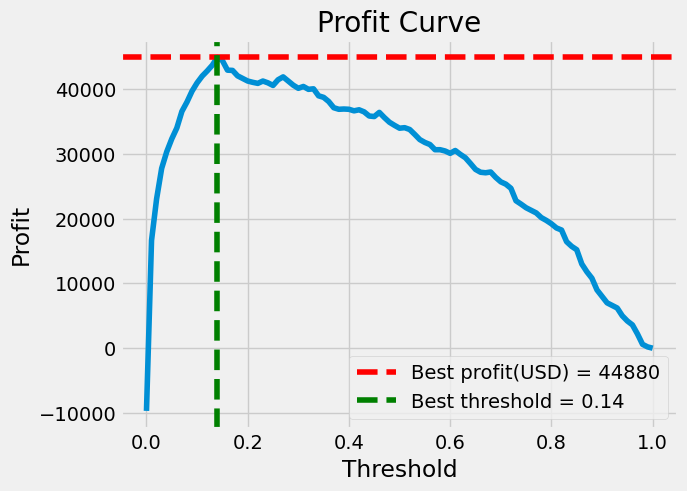

In [49]:
plot_profit_curve(synth_pred_thresholds,synth_pred_profits,synth_best_thresh,synth_best_profits)

In [50]:
print(f"Improving the model by {int(improvement_factor*100)}% percent could result in a profit of {synth_best_profits - best_profits} dollars ")

Improving the model by 14% percent could result in a profit of 13880 dollars 


#### Improving the model by 14% percent could result in a profit of **13.880** USD
